In [1]:
import numpy as np
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\Users\uzmap\Documents\GitHub\ForEx\all_data.csv')
df.drop('Unnamed: 0', axis =1, inplace = True)
df.head()

,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair
0,2014-11-07,61.390,61.620,61.340,61.400,USD/INR
1,2014-11-10,61.500,61.635,61.340,61.495,USD/INR
2,2014-11-11,61.530,61.555,61.505,61.508,USD/INR
3,2014-11-12,61.508,61.560,61.350,61.391,USD/INR
4,2014-11-13,61.368,61.623,61.350,61.565,USD/INR


In [3]:
usdinrSarima = df.loc[df['Currency Pair']=='USD/INR']
usdinrSarima.reset_index(drop=True,inplace=True)

In [4]:
usdinrSarima['Date']= pd.to_datetime(usdinrSarima['Date'])

In [5]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

for i in usdinrSarima.columns : 
  if i!='Currency Pair' :
    print("ADFuller test for column : ",i)
    check_stationarity(usdinrSarima[i])

ADFuller test for column :  Date
ADF Statistic: 0.588657
p-value: 0.987333
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Open_price
ADF Statistic: -0.561083
p-value: 0.879535
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Day_high
ADF Statistic: -0.658170
p-value: 0.857289
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Day_low
ADF Statistic: -0.502551
p-value: 0.891518
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test fo

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

def deseasonalize_column(data, column, period=7):
    """
    Deseasonalizes a column by decomposing it into trend, seasonality, and residual components.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the time series data.
    - column (str): The name of the column to deseasonalize.
    - period (int): The periodicity of the data (e.g., 7 for weekly seasonality).
    
    Returns:
    - pd.Series: The deseasonalized version of the column.
    """
    # Decompose the column
    decomposition = seasonal_decompose(data[column], model='additive', period=period, extrapolate_trend='freq')
    
    # Extract the residual component as deseasonalized data
    deseasonalized = data[column] - decomposition.seasonal
    
    return deseasonalized

# Identify non-stationary columns
non_stationary_columns = ['Day_high', 'Day_low', 'Open_price']

# Create deseasonalized columns
for col in non_stationary_columns:
    deseasonalized_col = deseasonalize_column(usdinrSarima, col, period=14)  # Adjust the period as needed
    usdinrSarima[f'Deseasonalized_{col}'] = deseasonalized_col


In [8]:
import swing_technical_indicators

usdinrSarima['EMA_50'] = swing_technical_indicators.calculate_100ema(usdinrSarima, 'Closing_price', 50)
usdinrSarima['EMA_100'] = swing_technical_indicators.calculate_100ema(usdinrSarima, 'Closing_price', 100)
usdinrSarima['EMA_200'] = swing_technical_indicators.calculate_200ema(usdinrSarima, 'Closing_price', 200)

In [9]:
usdinrSarima['RSI'] = swing_technical_indicators.calculate_rsi(usdinrSarima,'Closing_price',21)
usdinrSarima_macd = swing_technical_indicators.calculate_macd(usdinrSarima, column_name='Closing_price', short_period=12, long_period=26, signal_period=9)

for i in usdinrSarima_macd.columns:

    usdinrSarima[f"{i}"] = usdinrSarima_macd[f'{i}']
bollinger_data = swing_technical_indicators.calculate_bollinger_bands(usdinrSarima['Closing_price'])

usdinrSarima = usdinrSarima.join(bollinger_data)
usdinrSarima.drop('Price',axis=1, inplace=True)

In [10]:
usdinrSarima.head()

,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,2014-11-07,61.390,61.620,61.340,61.400,USD/INR,61.622383,61.360708,61.416374,61.400000,61.400000,61.400000,0.0,0.000000,0.000000,0.000000,61.7496,62.164424,61.334776
1,2014-11-10,61.500,61.635,61.340,61.495,USD/INR,61.622743,61.339113,61.498976,61.403725,61.401881,61.400945,0.0,0.007578,0.001516,0.006063,61.7496,62.164424,61.334776
2,2014-11-11,61.530,61.555,61.505,61.508,USD/INR,61.542058,61.494995,61.512086,61.407815,61.403983,61.402010,0.0,0.014466,0.004106,0.010361,61.7496,62.164424,61.334776
3,2014-11-12,61.508,61.560,61.350,61.391,USD/INR,61.558885,61.366357,61.500624,61.407155,61.403725,61.401901,0.0,0.010365,0.005358,0.005007,61.7496,62.164424,61.334776
4,2014-11-13,61.368,61.623,61.350,61.565,USD/INR,61.614428,61.352363,61.382335,61.413345,61.406919,61.403524,0.0,0.020914,0.008469,0.012445,61.7496,62.164424,61.334776


In [11]:
X = usdinrSarima.drop(['Date','Open_price','Day_high','Day_low','Closing_price','Currency Pair'],axis=1)
y =usdinrSarima['Closing_price']
columns = X.columns

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X = sc.fit_transform(X)
X= pd.DataFrame(X,columns = columns)

C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


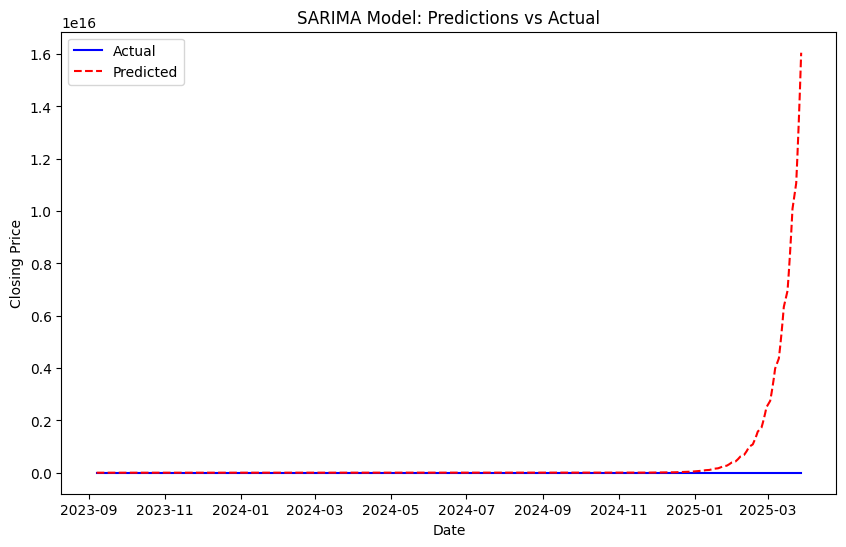

                                     SARIMAX Results                                      
Dep. Variable:                      Closing_price   No. Observations:                 2303
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -510.027
Date:                            Wed, 23 Jul 2025   AIC                           1032.054
Time:                                    18:56:11   BIC                           1066.435
Sample:                                         0   HQIC                          1044.595
                                           - 2303                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Date_numeric  2.364e-07   1.18e-07      1.999      0.046     4.6e-09    4.68e-07
ar.L1            1.0974      

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assume jpy_inr is your DataFrame with the 'Date' column and target 'Closing_price'
# Ensure 'Date' is in datetime format
usdinrSarima['Date'] = pd.to_datetime(usdinrSarima['Date'])

# Convert 'Date' to numeric (timestamp)
usdinrSarima['Date_numeric'] = usdinrSarima['Date'].apply(lambda x: x.timestamp())

# Set the target column
target = 'Closing_price'

# Train-Test Split (85%-15%)
train_size = int(len(usdinrSarima) * 0.85)
train, test = usdinrSarima[:train_size], usdinrSarima[train_size:]

# SARIMA Model: SARIMAX for seasonal data
sarima_model = SARIMAX(train[target], 
                       order=(1, 1, 1),  # AR, I, MA order
                       seasonal_order=(1, 1, 1, 12),  # Seasonal order
                       exog=train[['Date_numeric']],  # Include 'Date_numeric' as an exogenous variable
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

# Fit the model
sarima_fit = sarima_model.fit()

# Make predictions
predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, exog=test[['Date_numeric']])

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(test['Date'], test[target], label="Actual", color='blue')
plt.plot(test['Date'], predictions, label="Predicted", color='red', linestyle="--")
plt.legend()
plt.title("SARIMA Model: Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

# Optional: Print out model diagnostics
print(sarima_fit.summary())
